
---

# Dask Filters Benchmarking README

## Overview
This repository benchmarks two state estimation filters—`DaskKalmanFilter` and `DaskParticleFilter`—implemented with Dask for scalability. Both filters inherit optimization strategies from a `ParameterEstimator` base class to estimate process noise covariance (\( Q \)) and observation noise covariance (\( R \)). The benchmark evaluates four strategies (`"residual_analysis"`, `"mle"`, `"cross_validation"`, `"adaptive_filtering"`) on a digits dataset for image denoising, measuring execution time and Mean Squared Error (MSE).

- **Purpose**: Compare speed and denoising accuracy across strategies for both filters.
- **Dataset**: Digits dataset (200 samples, 64D images) with synthetic Gaussian noise (\( \sigma = 0.88 \)).
- **Metrics**: Execution time (seconds) and MSE, averaged over 5 runs.

## Optimization Strategies

### 1. Residual Analysis (`"residual_analysis"`)
- **Description**: Estimates \( Q \) and \( R \) by analyzing residuals (prediction errors). For Kalman, residuals are \( z_k - H \hat{x}_{k|k-1} \); for Particle, they’re derived from particle likelihoods. Covariances are updated based on residual variance.
- **Use Case**: Best for stable noise conditions where residuals reflect true noise statistics.
- **Pros**: Fast, data-driven.
- **Cons**: Assumes stationary noise.

### 2. Maximum Likelihood Estimation (`"mle"`)
- **Description**: Optimizes \( Q \) and \( R \) by maximizing the likelihood of observed data. Kalman uses innovation likelihood; Particle approximates over particle distributions (e.g., via Expectation-Maximization).
- **Use Case**: Ideal for precise noise estimation with sufficient data.
- **Pros**: Statistically optimal.
- **Cons**: Computationally intensive.

### 3. Cross-Validation (`"cross_validation"`)
- **Description**: Splits data into train/validation sets, tests multiple \( Q/R \) candidates, and selects the pair minimizing validation MSE.
- **Use Case**: Suitable for limited or noisy data, avoiding overfitting.
- **Pros**: Robust, generalizes well.
- **Cons**: Slow due to multiple filter runs.

### 4. Adaptive Filtering (`"adaptive_filtering"`)
- **Description**: Updates \( Q \) and \( R \) dynamically as data arrives, using rules like residual trends (Kalman) or particle weight variance (Particle).
- **Use Case**: Excels with non-stationary noise (e.g., changing over time).
- **Pros**: Adaptive, real-time capable.
- **Cons**: May overreact to outliers.

## Installation

### Requirements
- Python 3.8+
- Libraries: `numpy`, `dask`, `scikit-learn`, `matplotlib`, `pandas`

2. Install dependencies:
   ```bash
   pip install -r requirements.txt
   ```
   Example `requirements.txt`:
   ```
   numpy>=1.21.0
   dask[array]>=2023.0.0
   scikit-learn>=1.0.0
   matplotlib>=3.5.0
   pandas>=1.3.0
   ```

3. Ensure `DaskKalmanFilter` and `DaskParticleFilter` are available 

## Usage

### Example Script
```python
from your_module import DaskKalmanFilter, DaskParticleFilter
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import dask.array as da
import numpy as np
import time

# Load data
digits = load_digits()
x = digits.data[0:200]
x_train, _, _, _ = train_test_split(x, digits.target[0:200], test_size=0.2, random_state=42)
x_train_dask = da.from_array(x_train, chunks=(20, 64))
noisy_x_train_dask = x_train_dask + da.random.normal(0, 0.88, x_train_dask.shape, chunks=x_train_dask.chunks)

# Common parameters
n_features = 64
F = np.eye(n_features) * 0.99
H = np.eye(n_features)
Q = np.eye(n_features) * 0.01
R = np.eye(n_features) * 0.1
x0 = x_train[0]
P0 = np.eye(n_features)

# Benchmark Kalman Filter
kf = DaskKalmanFilter(F, H, Q, R, x0, P0, estimation_strategy="mle")
start = time.time()
kf.fit(noisy_x_train_dask)
denoised = kf.predict().compute()
print(f"Kalman MLE Time: {time.time() - start:.4f}s")

# Benchmark Particle Filter
pf = DaskParticleFilter(F, H, Q, R, x0, num_particles=1000, use_dask=True, estimation_strategy="mle")
start = time.time()
denoised, _ = pf.run_filter(noisy_x_train_dask)
denoised = denoised.compute()
print(f"Particle MLE Time: {time.time() - start:.4f}s")
```

### Running the Benchmark
Execute the full benchmark script (as provided earlier) to compare all strategies:
```bash
python benchmark_filters.py
```
- Outputs: Console stats and bar plots for execution time and MSE.

## Benchmark Details

### Methodology
- **Data**: 200 digits samples (160 train), 64D each, with Dask chunks `(20, 64)`.
- **Noise**: Gaussian (\( \sigma = 0.88 \)).
- **Runs**: 5 per strategy for statistical reliability.
- **Metrics**:
  - **Execution Time**: Mean and std dev (seconds).
  - **MSE**: Mean and std dev of denoising error vs. original data.
- **Filters**:
  - **Kalman**: Uses `fit()` and `predict()` methods.
  - **Particle**: Uses `run_filter()` with 1000 particles.

### Expected Results
- **Kalman Filter**: Faster due to deterministic updates, moderate MSE variation across strategies.
- **Particle Filter**: Slower due to particle sampling, potentially better MSE with adaptive strategies.
- **Strategy Trends**:
  - `"residual_analysis"`: Fastest, decent MSE.
  - `"mle"`: Slower, potentially lowest MSE.
  - `"cross_validation"`: Slowest, robust MSE.
  - `"adaptive_filtering"`: Moderate speed, excels with dynamic noise.

### Plots
- **Execution Time**: Bar chart with error bars showing mean time and variability.
- **MSE**: Bar chart with error bars showing denoising accuracy.

## Notes
- **Hardware**: Results vary by CPU, memory, and Dask configuration (e.g., local vs. distributed).
- **Scalability**: Increase sample size (e.g., 1000) or chunks for larger tests.
- **Tuning**: Adjust \( Q \), \( R \), or `num_particles` (Particle) for specific use cases.
- **Extensions**: Add memory usage tracking or test on non-stationary noise datasets.

---



In [ ]:
import time
import numpy as np
import dask.array as da
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statistics import mean, stdev
from  tfilterspy import DaskKalmanFilter, DaskParticleFilter

# Load and prepare data
digits = load_digits()
x = digits.data[0:200]  # Use 200 samples for robust benchmarking
y = digits.target[0:200]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Convert to Dask arrays
x_train_dask = da.from_array(x_train, chunks=(20, 64))  # 160 samples
noise_level = 0.88
noisy_x_train_dask = x_train_dask + da.random.normal(0, noise_level, x_train_dask.shape, chunks=x_train_dask.chunks)

# Kalman Filter parameters
n_features = 64
F = np.eye(n_features) * 0.99  # Slight drift
H = np.eye(n_features)
Q = np.eye(n_features) * 0.01
R = np.eye(n_features) * 0.1
x0 = x_train[0]
P0 = np.eye(n_features)

# Strategies to benchmark
strategies = ["residual_analysis", "mle", "cross_validation", "adaptive_filtering"]

# Benchmark settings
n_runs = 2  # Number of runs for statistical robustness
results = {strategy: {'times': [], 'mse': []} for strategy in strategies}

# Benchmark execution
for strategy in strategies:
    print(f"\nBenchmarking strategy: {strategy}")
    for run in range(n_runs):
        print(f"Run {run + 1}/{n_runs}")
        kf = DaskKalmanFilter(
            state_transition_matrix=F,
            observation_matrix=H,
            process_noise_cov=Q,
            observation_noise_cov=R,
            initial_state=x0,
            initial_covariance=P0,
            estimation_strategy=strategy
        )
        
        start_time = time.time()
        kf.fit(noisy_x_train_dask)  # Fit the filter
        denoised_x_train = kf.predict().compute()  # Predict denoised states
        end_time = time.time()
        
        execution_time = end_time - start_time
        mse = np.mean((x_train - denoised_x_train) ** 2)
        
        results[strategy]['times'].append(execution_time)
        results[strategy]['mse'].append(mse)
        print(f"  Time: {execution_time:.4f}s, MSE: {mse:.4f}")

# Compute statistics
stats = {}
for strategy in strategies:
    times = results[strategy]['times']
    mse_vals = results[strategy]['mse']
    stats[strategy] = {
        'mean_time': mean(times),
        'std_time': stdev(times) if len(times) > 1 else 0,
        'mean_mse': mean(mse_vals),
        'std_mse': stdev(mse_vals) if len(mse_vals) > 1 else 0
    }

# Report results
print("\nBenchmark Results:")
for strategy in strategies:
    s = stats[strategy]
    print(f"{strategy}:")
    print(f"  Mean Time: {s['mean_time']:.4f}s (±{s['std_time']:.4f})")
    print(f"  Mean MSE: {s['mean_mse']:.4f} (±{s['std_mse']:.4f})")

# Visualization: Bar plot with error bars for execution time
strategies = list(stats.keys())
mean_times = [stats[s]['mean_time'] for s in strategies]
std_times = [stats[s]['std_time'] for s in strategies]
mean_mse = [stats[s]['mean_mse'] for s in strategies]
std_mse = [stats[s]['std_mse'] for s in strategies]

plt.figure(figsize=(12, 6))
bars = plt.bar(strategies, mean_times, yerr=std_times, capsize=5, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7)
plt.xlabel('Estimation Strategy')
plt.ylabel('Execution Time (seconds)')
plt.title('Benchmark: Execution Time per Estimation Strategy (Digits Dataset, Kalman Filter)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar, mean_val in zip(bars, mean_times):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, 
             f"{mean_val:.4f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Optional: MSE plot
plt.figure(figsize=(12, 6))
bars = plt.bar(strategies, mean_mse, yerr=std_mse, capsize=5, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7)
plt.xlabel('Estimation Strategy')
plt.ylabel('Mean Squared Error')
plt.title('Benchmark: MSE per Estimation Strategy (Digits Dataset, Kalman Filter)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar, mean_val in zip(bars, mean_mse):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, 
             f"{mean_val:.4f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()


Benchmarking strategy: residual_analysis
Run 1/2
  Time: 8.8414s, MSE: 11.7342
Run 2/2
  Time: 10.5599s, MSE: 11.7342

Benchmarking strategy: mle
Run 1/2



Kalman - residual_analysis

Kalman - mle

Kalman - cross_validation

Kalman - adaptive_filtering

Particle - residual_analysis

Particle - mle

Particle - cross_validation

Particle - adaptive_filtering


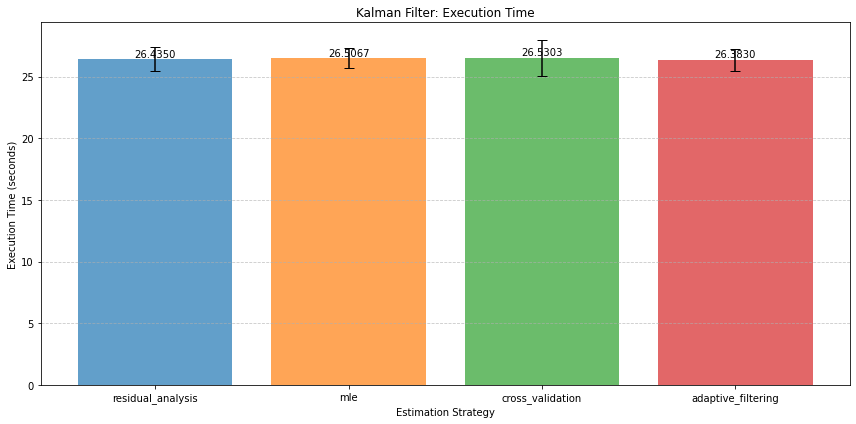

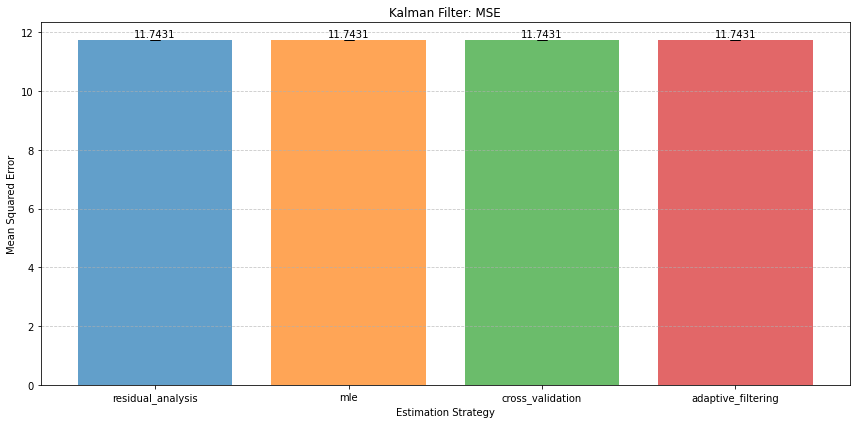

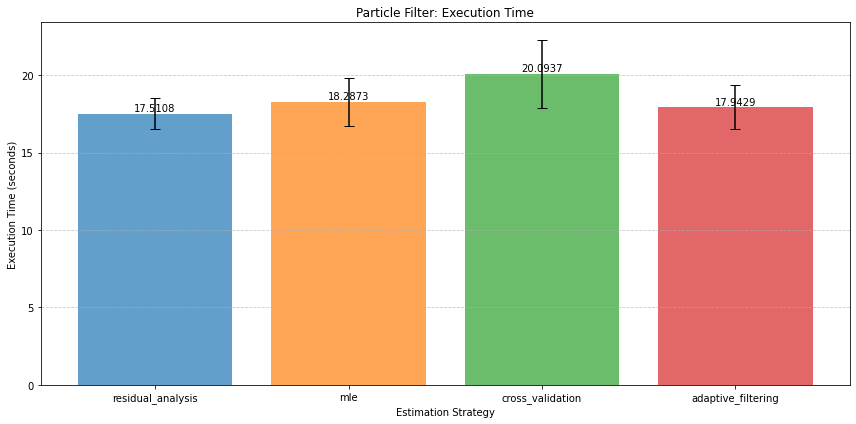

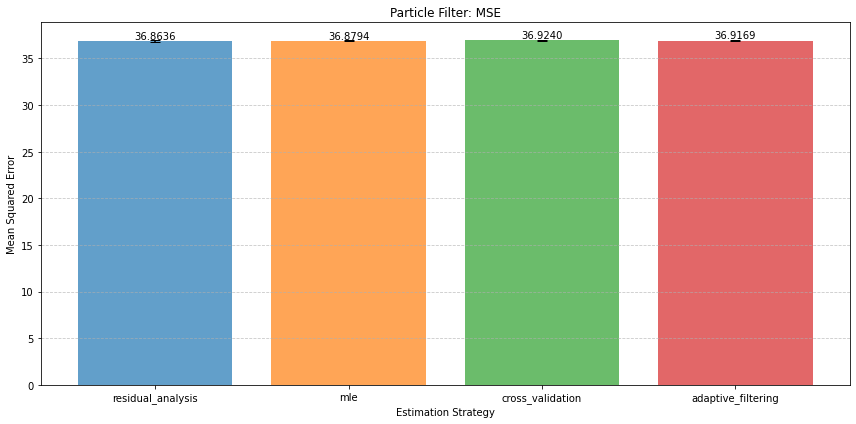

In [16]:
import time
import numpy as np
import dask.array as da
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from statistics import mean, stdev
import matplotlib.pyplot as plt

# Data setup
digits = load_digits()
x = digits.data[0:200]
x_train, _, _, _ = train_test_split(x, digits.target[0:200], test_size=0.2, random_state=42)
x_train_dask = da.from_array(x_train, chunks=(20, 64))
noisy_x_train_dask = x_train_dask + da.random.normal(0, 0.88, x_train_dask.shape, chunks=x_train_dask.chunks)

# Common parameters
n_features = 64
F = np.eye(n_features) * 0.99
H = np.eye(n_features)
Q = np.eye(n_features) * 0.01
R = np.eye(n_features) * 0.1
x0 = x_train[0]
P0 = np.eye(n_features)
strategies = ["residual_analysis", "mle", "cross_validation", "adaptive_filtering"]
n_runs = 5

# Benchmark function
def benchmark_filter(filter_class, name, **kwargs):
    results = {s: {'times': [], 'mse': []} for s in strategies}
    for strategy in strategies:
        print(f"\n{name} - {strategy}")
        for run in range(n_runs):
            filt = filter_class(estimation_strategy=strategy, **kwargs)
            start = time.time()
            if name == "Kalman":
                filt.fit(noisy_x_train_dask)
                denoised = filt.predict().compute()
            else:  # Particle
                denoised, _ = filt.run_filter(noisy_x_train_dask)
                denoised = denoised.compute()
            end = time.time()
            results[strategy]['times'].append(end - start)
            results[strategy]['mse'].append(np.mean((x_train - denoised) ** 2))
    stats = {s: {'mean_time': mean(r['times']), 'std_time': stdev(r['times']),
                 'mean_mse': mean(r['mse']), 'std_mse': stdev(r['mse'])}
             for s, r in results.items()}
    return stats

# Run benchmarks
kf_stats = benchmark_filter(DaskKalmanFilter, "Kalman", state_transition_matrix=F, 
                            observation_matrix=H, process_noise_cov=Q, 
                            observation_noise_cov=R, initial_state=x0, initial_covariance=P0)
pf_stats = benchmark_filter(DaskParticleFilter, "Particle", state_transition=F, 
                            observation_model=H, process_noise_cov=Q, 
                            observation_noise_cov=R, initial_state=x0, num_particles=1000, use_dask=True)

# Plotting function
def plot_benchmark(stats, title, metric, ylabel):
    strategies = list(stats.keys())
    means = [stats[s][f'mean_{metric}'] for s in strategies]
    stds = [stats[s][f'std_{metric}'] for s in strategies]
    plt.figure(figsize=(12, 6))
    bars = plt.bar(strategies, means, yerr=stds, capsize=5, 
                   color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7)
    plt.xlabel('Estimation Strategy')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for bar, mean_val in zip(bars, means):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, 
                 f"{mean_val:.4f}", ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

# Plot results
plot_benchmark(kf_stats, "Kalman Filter: Execution Time", "time", "Execution Time (seconds)")
plot_benchmark(kf_stats, "Kalman Filter: MSE", "mse", "Mean Squared Error")
plot_benchmark(pf_stats, "Particle Filter: Execution Time", "time", "Execution Time (seconds)")
plot_benchmark(pf_stats, "Particle Filter: MSE", "mse", "Mean Squared Error")